In [60]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import pyaudio
import scipy
import lcapy as lc
from lcapy.discretetime import z

In [ ]:
def playAudio():
    #function for playing audio
    filename = WAVE_OUTPUT_FILENAME

    # Set chunk size of 1024 samples per data frame
    chunk = 1024  

    # Open the sound file 
    wf = wave.open(filename, 'rb')

    # Create an interface to PortAudio
    p = pyaudio.PyAudio()

    # Open a .Stream object to write the WAV file to
    # 'output = True' indicates that the sound will be played rather than recorded
    stream = p.open(format = p.get_format_from_width(wf.getsampwidth()),
                    channels = wf.getnchannels(),
                    rate = wf.getframerate(),
                    output = True)

    # Read data in chunks
    data = wf.readframes(chunk)

    # Play the sound by writing the audio data to the stream
    while data != '':
        stream.write(data)
        data = wf.readframes(chunk)

    # Close and terminate the stream
    stream.close()
    p.terminate()

In [92]:
def recordAudio():
    save_rep = input('Do you want to save your audio in a new file (could be useful for offline processing? (Y/N)\n')
    if save_rep == 'Y' or save_rep == 'y':
        filename = input('What do you want the audio file name to be? {format: <entername>.wav}\n ')
    else:
        filename = "input.wav"
    secs = int(input("How long do you want the input to be (in seconds)?\n")) 
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = secs
    WAVE_OUTPUT_FILENAME = filename
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
        

    print("Audio recorded!")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    print("Here's a plot of your raw input!")
    spf = wave.open(WAVE_OUTPUT_FILENAME, 'r')

    #Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')

    plt.figure(1)
    plt.title('Signal Wave')
    plt.plot(signal)
    s = input('continue?' )
    return signal

In [110]:
#LCCDE coeffs
def HzLCCDE():
    print('I am assuming that this system is LTI\n')
    a_k = []
    b_m = []
    ylen = int(input('Enter lenght of y[k] (starting with y[n] and going up to the last non-zero coeff of y[k]): '))
    for i in range(0, ylen):
        p = int(input())
        a_k.append(p) #append the ith coeff of y[k] to the list of coeffs of y[k]
    xlen = int(input('Enter lenght of x[m] (starting with x[n] and going up to the last non-zero coeff of x[m]): '))
    for i in range(0, xlen):
        p = int(input())
        b_m.append(p) #append the ith coeff of x[m] to thr list of coeffs of x[m]
    l = np.maximum(ylen,xlen)  
    print(l)
    x_n = recordAudio()
    N = len(x_n)
    y_n = np.zeros(N)
    for i in range(l,N):
        for k in range (1, ylen):
            y_n[i] -= a_k[k]*y_n[i-k]
        for m in range (0, xlen):
            y_n[i] += b_m[k]*x_n[i-k]
        y_n[i] = y_n[i]/a_k[0]
        
    p = pyaudio.PyAudio()
    
    wf = wave.open('output.wav', 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(44100)
    wf.writeframes(b''.join(y_n))
    wf.close()

    print("Here's a plot of your filtered output!")
    spf = wave.open('output.wav', 'r')

    #Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')

    plt.figure(1)
    plt.title('Output Signal Wave')
    plt.plot(signal) 

In [105]:
#poles-zeros of H(z)
def HzPoleZero():
    zeros = []
    poles = []
    a = int(input('Enter number of zeros: '))
    for i in range(0, a):
        p = int(input())
        zeros.append(p) #append the ith zero to the list of zeros

    b = int(input('Enter number of poles: '))
    for j in range(0, b):
        k = int(input())
        poles.append(k) #append the jth pole to the list of poles
    num = np.poly1d(zeros, True, variable = 'z')
    print(num)
    den = np.poly1d(poles, True, variable = 'z')
    print(den)
    return [num/den]


In [106]:
#impulse response
def HzImpulseResponse():
    N = int(input('What is the length of your impulse response h[n]? : '))
    h_n = []
    d_n = [1]
    print('Please enter the values of h[t], starting from 0 and going to N-1:\n')
    for i in range(0, N):
        p = int(input())
        h_n.append(p) #append the ith impulse to the list of impulses
    #forming a series d[n], to obtain z^N as the denominator 
    for j in range(0,N-1):
        d_n.append(0) #append a zero to d[n]
    print('h[n] = ', h_n)
    num = np.poly1d(h_n, variable = 'z')
    print(num)
    den = np.poly1d(d_n, variable = 'z')
    print(den)
    return [num/den]
    

In [107]:
#ask for name, to personalize the user experience
user_name = input('Please enter your name:\n')
print('Hey',user_name,'!')
print('Thanks for using my audio filtering platform!')
print("Let's start by designing our filter\n")
#ask the user what type of input they want to use
option = input("Would you like to design your own filter using,\nA. LCCDE coefficients?\nB. poles and zeros of transfer function H(z)?\nC. impulse response h[n]?\n")

Please enter your name:
Shivangi
Hey Shivangi !
Thanks for using my audio filtering platform!
Let's start by designing our filter

Would you like to design your own filter using,
A. LCCDE coefficients?
B. poles and zeros of transfer function H(z)?
C. impulse response h[n]?
A


I am assuming that this system is LTI

Enter lenght of y[k] (starting with y[n] and going up to the last non-zero coeff of y[k]): 4
1
2
2
1
Enter lenght of x[m] (starting with x[n] and going up to the last non-zero coeff of x[m]): 4
1
2
2
1
4
Do you want to save your audio in a new file (could be useful for offline processing? (Y/N)
n
How long do you want the input to be (in seconds)?
5
* recording


/home/randomshit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/home/randomshit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Audio recorded!
Here's a plot of your raw input!
continue?y


Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f72ead59a58>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/usr/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Here's a plot of your filtered output!


/home/randomshit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/home/randomshit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


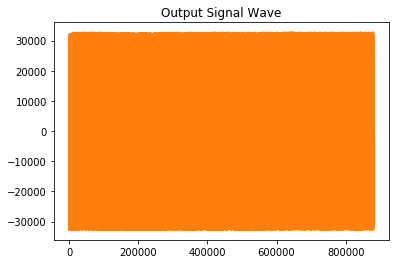

In [111]:
#main block for constructing the filter
Hz = np.poly1d(1)
if option == 'A' or option == 'a':
    HzLCCDE()
    Hz = 0
elif option == 'B' or option == 'b':
    Hz = HzPoleZero()
elif option == 'C' or option == 'c':
    Hz = HzImpulseResponse()
else:
    option = input('Enter a valid option (A/B/C)')


## input_stream = recordAudio(Hz)